In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

## Data imports

In [ ]:
# read data for chicken farm
data_for_model = pd.read_csv(r'C:\Users\Shivm\Documents\Masters\Research Project\Eskom air quality data\Eskom Model\PM10 Models\Combined Station Data.csv')
#data_for_model.drop(columns=['anomaly'], inplace=True)
data_for_model = data_for_model[data_for_model['Location_Chicken Farm']==True]
data_for_model['NO1'] = data_for_model['NO1'].fillna(data_for_model['NOX'] - data_for_model['NO2'])
data_for_model

,Date,Wind,Wind Dir,SO2,NO2,NOX,PM10,wind_x,wind_y,PM2.5,Pressure,Temp,NO1,Date Time,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,wind_x_lag1,wind_y_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,wind_x_roll3_mean,wind_x_roll3_std,wind_x_roll6_mean,wind_x_roll6_std,wind_x_roll12_mean,wind_x_roll12_std,wind_x_roll24_mean,wind_x_roll24_std,wind_y_roll3_mean,wind_y_roll3_std,wind_y_roll6_mean,wind_y_roll6_std,wind_y_roll12_mean,wind_y_roll12_std,wind_y_roll24_mean,wind_y_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Camden,Location_Chicken Farm,Location_Grootvlei,Location_Komati,Location_Marapong,Location_Medupi,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend
170376,2016/01/01 00:00:00,2.329133,354.089400,3.705,1.414,15.72,NaN,-0.239846,2.316751,NaN,847.0,21.26,15.470,2016-01-01 00:00:00,0.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.329133,NaN,2.329133,NaN,2.329133,NaN,2.329133,NaN,354.089400,NaN,354.089400,NaN,354.089400,NaN,354.089400,NaN,3.705000,NaN,3.705000,NaN,3.705000,NaN,3.705000,NaN,1.414000,NaN,1.414000,NaN,1.414000,NaN,1.414000,NaN,15.720000,NaN,15.720000,NaN,15.720000,NaN,15.720000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.239846,NaN,-0.239846,NaN,-0.239846,NaN,-0.239846,NaN,2.316751,NaN,2.316751,NaN,2.316751,NaN,2.316751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,847.000000,NaN,847.000000,NaN,847.000000,NaN,847.000000,NaN,21.260000,NaN,21.260000,NaN,21.260000,NaN,21.260000,NaN,15.470000,NaN,15.470000,NaN,15.470000,NaN,15.470000,NaN,False,True,False,False,False,False,False,False,False,True,False,True,False
170377,2016/01/01 00:10:00,2.495695,347.291100,4.064,4.243,13.44,NaN,-0.549047,2.434551,NaN,847.0,20.61,9.950,2016-01-01 00:10:00,0.0,1.0,4.0,2.329133,354.089400,3.705,1.414,15.72,NaN,-0.239846,2.316751,NaN,847.0,21.26,15.470,2.412414,0.117777,2.412414,0.117777,2.412414,0.117777,2.412414,0.117777,350.690250,4.807124,350.690250,4.807124,350.690250,4.807124,350.690250,4.807124,3.884500,0.253851,3.884500,0.253851,3.884500,0.253851,3.884500,0.253851,2.828500,2.000405,2.828500,2.000405,2.828500,2.000405,2.828500,2.000405,14.580000,1.612203,14.580000,1.612203,14.580000,1.612203,14.580000,1.612203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.394447,0.218638,-0.394447,0.218638,-0.394447,0.218638,-0.394447,0.218638,2.375651,0.083298,2.375651,0.083298,2.375651,0.083298,2.375651,0.083298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,847.000000,0.00000,847.000000,0.000000,847.000000,0.000000,847.000000,0.000000,20.935000,0.459619,20.935000,0.459619,20.935000,0.459619,20.935000,0.459619,12.710000,3.903229,12.710000,3.903229,12.710000,3.903229,12.710000,3.903229,False,True,False,False,F

In [14]:
#null checks
data_for_model.isna().sum()

Date                  0
Wind                  0
Wind Dir              6
SO2                2971
NO2                8906
                   ... 
Season_Spring         0
Season_Summer         0
Season_Winter         0
DayType_Weekday       0
DayType_Weekend       0
Length: 138, dtype: int64

In [15]:
data_for_model['Date Time'] = pd.to_datetime(data_for_model['Date Time'])
data_for_model['Year'] = data_for_model['Date Time'].dt.year
data_for_model.drop(columns=['Date', 'Date Time'], inplace=True)


In [16]:
data_for_model.columns

Index(['Wind', 'Wind Dir', 'SO2', 'NO2', 'NOX', 'PM10', 'wind_x', 'wind_y',
       'PM2.5', 'Pressure',
       ...
       'Location_Marapong', 'Location_Medupi', 'Location_Phola',
       'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'DayType_Weekday', 'DayType_Weekend', 'Year'],
      dtype='object', length=137)

## Create Target variable and rolling features

In [17]:
data_for_model['PM2.5_lag1'] = data_for_model['PM2.5'].shift(1)
data_for_model['PM2.5_lag2'] = data_for_model['PM2.5'].shift(2)
data_for_model['PM2.5_lag3'] = data_for_model['PM2.5'].shift(3)
data_for_model['PM2.5_t+1'] = data_for_model['PM2.5'].shift(-1)



# Rolling means with different windows, shifted by 1 to prevent leakage
data_for_model['PM2.5_diff1'] = data_for_model['PM2.5'] - data_for_model['PM2.5'].shift(1)
data_for_model['Temp_diff1'] = data_for_model['Temp'] - data_for_model['Temp'].shift(1)


data_for_model = data_for_model.dropna().reset_index(drop=True)
# # # Split by year
df_train = data_for_model[(data_for_model['Year'] >= 2005) & (data_for_model['Year'] <= 2016)]
df_test = data_for_model[data_for_model['Year'] == 2017]
df_val = data_for_model[data_for_model['Year'] == 2018]


In [18]:
data_for_model

,Wind,Wind Dir,SO2,NO2,NOX,PM10,wind_x,wind_y,PM2.5,Pressure,Temp,NO1,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,wind_x_lag1,wind_y_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,wind_x_roll3_mean,wind_x_roll3_std,wind_x_roll6_mean,wind_x_roll6_std,wind_x_roll12_mean,wind_x_roll12_std,wind_x_roll24_mean,wind_x_roll24_std,wind_y_roll3_mean,wind_y_roll3_std,wind_y_roll6_mean,wind_y_roll6_std,wind_y_roll12_mean,wind_y_roll12_std,wind_y_roll24_mean,wind_y_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Camden,Location_Chicken Farm,Location_Grootvlei,Location_Komati,Location_Marapong,Location_Medupi,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend,Year,PM2.5_lag2,PM2.5_lag3,PM2.5_t+1,PM2.5_diff1,Temp_diff1
0,7.156286,91.86486,13.810,1.324,10.920,146.10,7.152496,-0.232881,53.25,844.0,22.32,14.190,16.0,1.0,4.0,6.538234,94.81412,17.24,1.212,12.660,141.30,6.515168,-0.548711,51.60,843.0,22.84,15.760,6.545746,0.606818,6.248888,0.521865,5.386216,1.413779,3.545463,2.143104,96.116160,5.030330,100.225297,5.786552,88.152249,28.361182,146.442456,131.768226,17.203333,3.375149,21.300000,4.977252,21.278833,10.671948,13.049708,11.186610,1.234333,0.080848,1.241667,0.340487,1.187333,0.432131,1.375333,0.775626,13.756667,3.515712,16.935000,4.484880,17.952500,7.249993,15.574583,5.792939,139.366667,7.879932,137.300000,7.647222,137.300000,7.647222,137.300000,7.647222,6.495850,0.666515,6.128177,0.590215,5.041310,1.851542,2.433458,2.988820,-0.661201,0.494260,-1.070225,0.585140,-0.465186,1.502653,0.554899,1.508712,50.580000,3.300409,52.077500,4.028874,52.077500,4.028874,52.077500,4.028874,843.666667,0.57735,843.500000,0.547723,843.666667,0.492366,843.916667,0.503610,22.580000,0.260000,23.235000,0.966969,25.302500,2.711645,26.733333,2.422481,16.306667,2.436439,20.715000,5.399803,21.385833,7.870918,17.270000,6.932891,False,True,False,False,False,False,False,False,False,True,False,True,False,2016,46.89,56.57,51.61,1.65,-0.52
1,6.355300,99.27425,9.970,1.302,13.420,146.40,6.272225,-1.024222,51.61,844.0,21.94,15.790,16.0,1.0,4.0,7.156286,91.86486,13.81,1.324,10.920,146.10,7.152496,-0.232881,53.25,844.0,22.32,14.190,6.683273,0.419728,6.280493,0.521559,5.701327,1.121093,3.740211,2.178418,95.317743,3.730280,98.996705,4.858929,93.506458,22.972262,149.833313,129.341140,13.673333,3.636926,18.690000,6.206651,21.722583,10.007441,13.262250,11.072296,1.279333,0.059341,1.152000,0.188178,1.206083,0.431790,1.301500,0.686066,12.333333,1.281614,15.295000,3.369948,17.910000,7.277161,15.450833,5.806469,144.600000,2.861818,139.120000,7.773159,139.120000,7.773159,139.120000,7.773159,6.646630,0.454621,6.189000,0.581641,5.4

## Correlation Matrix to identify best features

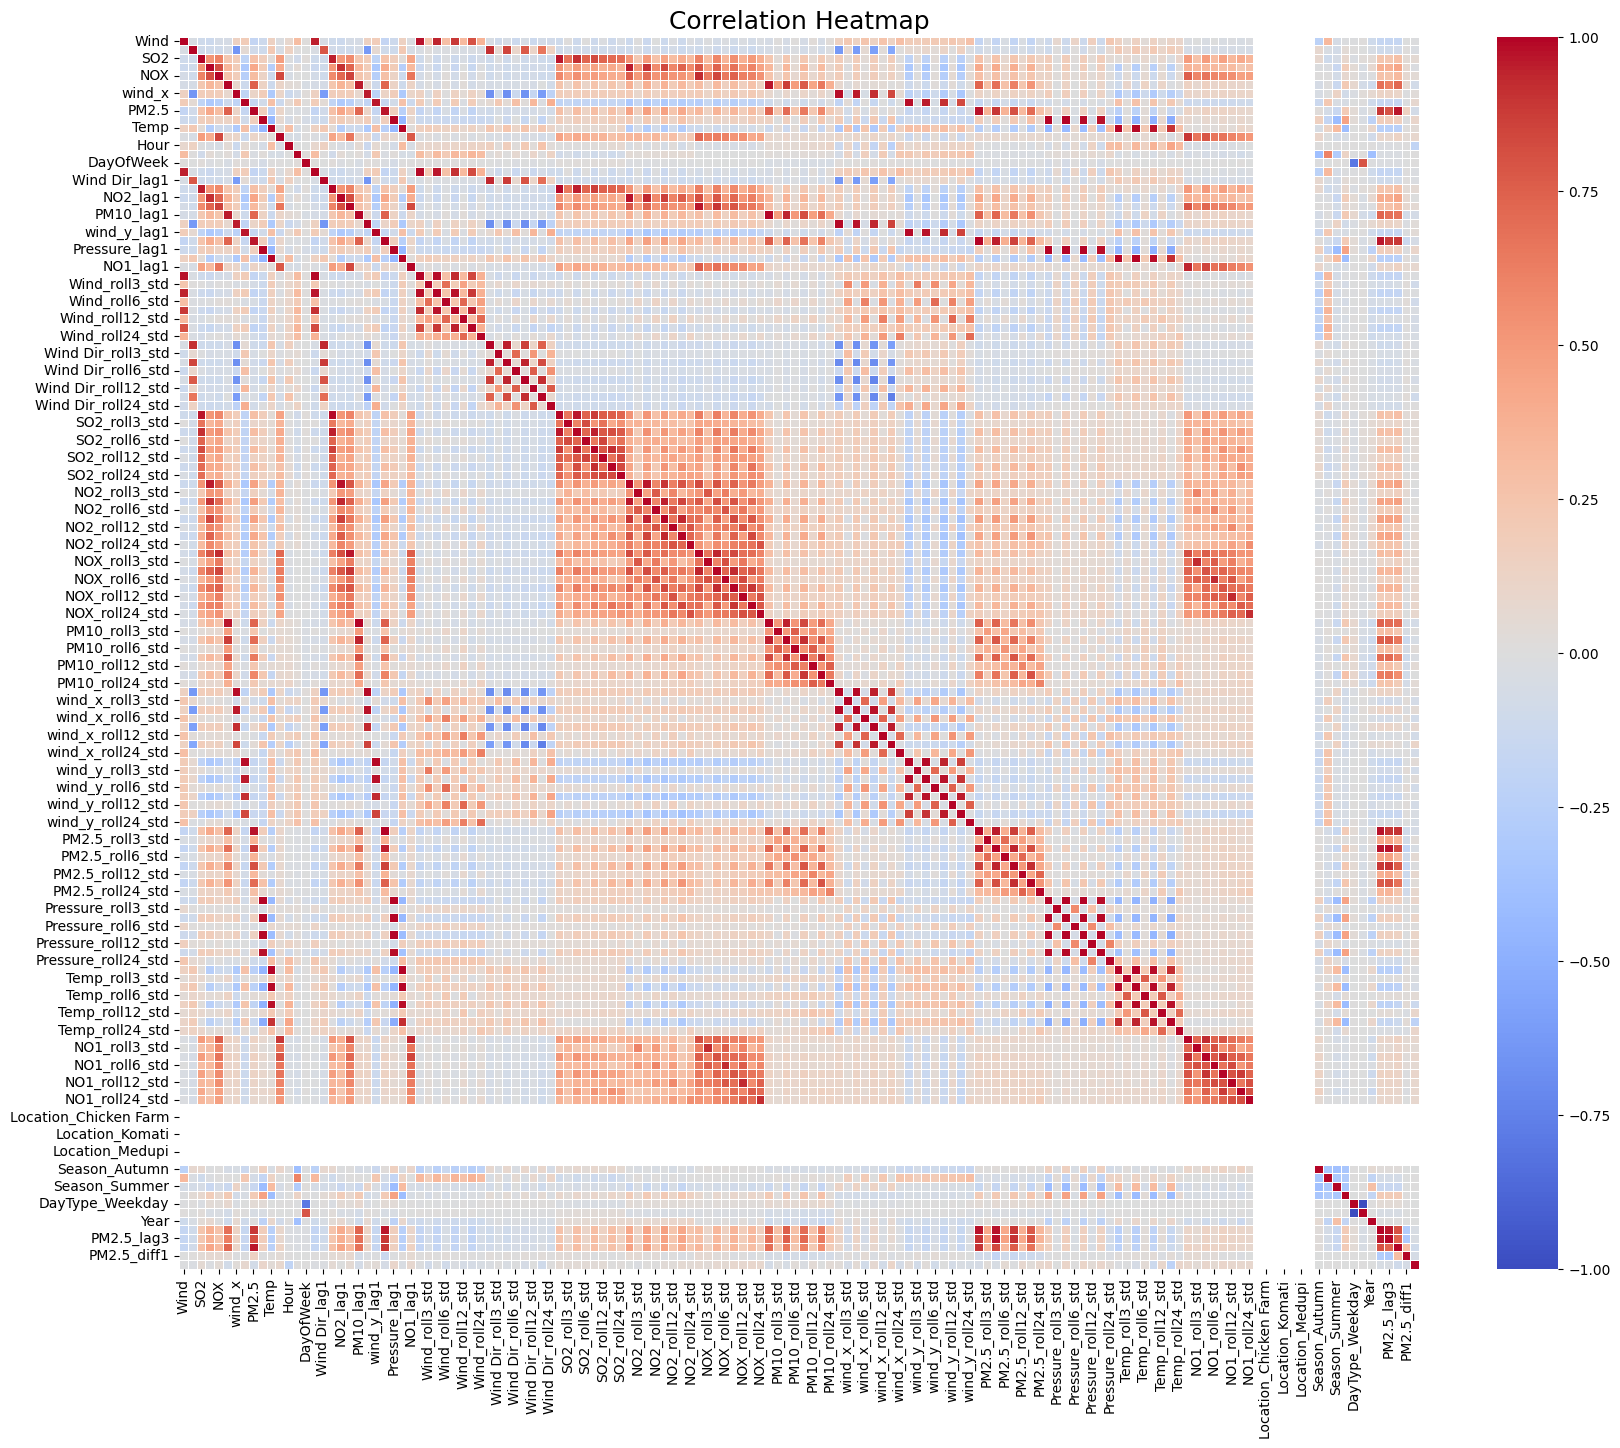

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = data_for_model.corr()

# Set up the matplotlib figure
plt.figure(figsize=(20, 16))

# Generate a heatmap
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)

# Add title
plt.title('Correlation Heatmap', fontsize=18)
plt.show()


In [20]:
# Compute correlations with the target
target = 'PM2.5_t+1'
correlations = data_for_model.corr()[target].drop(target)

# Sort by absolute correlation (strongest relationships first)
feature_ranking = correlations.abs().sort_values(ascending=False)

# Display top 15 features most correlated with PM2.5_t+12
print("Top correlated features with PM2.5_t+1:\n")
print(feature_ranking.head(20))

Top correlated features with PM2.5_t+1:

PM2.5                0.961783
PM2.5_roll3_mean     0.900462
PM2.5_lag1           0.883107
PM2.5_roll6_mean     0.831912
PM2.5_lag2           0.800179
PM2.5_roll12_mean    0.761416
PM2.5_lag3           0.728369
PM10                 0.723950
PM10_roll3_mean      0.692264
PM10_lag1            0.676297
PM2.5_roll24_mean    0.671952
PM10_roll6_mean      0.655565
PM10_roll12_mean     0.611566
PM10_roll24_mean     0.555386
NO2_roll6_mean       0.463757
NO2_roll3_mean       0.458881
NO2_lag1             0.444537
NO2_roll12_mean      0.442629
NO2                  0.434390
NO2_roll24_mean      0.401364
Name: PM2.5_t+1, dtype: float64


In [21]:
feature_ranking

PM2.5                 0.961783
PM2.5_roll3_mean      0.900462
PM2.5_lag1            0.883107
PM2.5_roll6_mean      0.831912
PM2.5_lag2            0.800179
                        ...   
Location_Grootvlei         NaN
Location_Komati            NaN
Location_Marapong          NaN
Location_Medupi            NaN
Location_Phola             NaN
Name: PM2.5_t+1, Length: 141, dtype: float64

In [22]:
data_for_model

,Wind,Wind Dir,SO2,NO2,NOX,PM10,wind_x,wind_y,PM2.5,Pressure,Temp,NO1,Hour,Month,DayOfWeek,Wind_lag1,Wind Dir_lag1,SO2_lag1,NO2_lag1,NOX_lag1,PM10_lag1,wind_x_lag1,wind_y_lag1,PM2.5_lag1,Pressure_lag1,Temp_lag1,NO1_lag1,Wind_roll3_mean,Wind_roll3_std,Wind_roll6_mean,Wind_roll6_std,Wind_roll12_mean,Wind_roll12_std,Wind_roll24_mean,Wind_roll24_std,Wind Dir_roll3_mean,Wind Dir_roll3_std,Wind Dir_roll6_mean,Wind Dir_roll6_std,Wind Dir_roll12_mean,Wind Dir_roll12_std,Wind Dir_roll24_mean,Wind Dir_roll24_std,SO2_roll3_mean,SO2_roll3_std,SO2_roll6_mean,SO2_roll6_std,SO2_roll12_mean,SO2_roll12_std,SO2_roll24_mean,SO2_roll24_std,NO2_roll3_mean,NO2_roll3_std,NO2_roll6_mean,NO2_roll6_std,NO2_roll12_mean,NO2_roll12_std,NO2_roll24_mean,NO2_roll24_std,NOX_roll3_mean,NOX_roll3_std,NOX_roll6_mean,NOX_roll6_std,NOX_roll12_mean,NOX_roll12_std,NOX_roll24_mean,NOX_roll24_std,PM10_roll3_mean,PM10_roll3_std,PM10_roll6_mean,PM10_roll6_std,PM10_roll12_mean,PM10_roll12_std,PM10_roll24_mean,PM10_roll24_std,wind_x_roll3_mean,wind_x_roll3_std,wind_x_roll6_mean,wind_x_roll6_std,wind_x_roll12_mean,wind_x_roll12_std,wind_x_roll24_mean,wind_x_roll24_std,wind_y_roll3_mean,wind_y_roll3_std,wind_y_roll6_mean,wind_y_roll6_std,wind_y_roll12_mean,wind_y_roll12_std,wind_y_roll24_mean,wind_y_roll24_std,PM2.5_roll3_mean,PM2.5_roll3_std,PM2.5_roll6_mean,PM2.5_roll6_std,PM2.5_roll12_mean,PM2.5_roll12_std,PM2.5_roll24_mean,PM2.5_roll24_std,Pressure_roll3_mean,Pressure_roll3_std,Pressure_roll6_mean,Pressure_roll6_std,Pressure_roll12_mean,Pressure_roll12_std,Pressure_roll24_mean,Pressure_roll24_std,Temp_roll3_mean,Temp_roll3_std,Temp_roll6_mean,Temp_roll6_std,Temp_roll12_mean,Temp_roll12_std,Temp_roll24_mean,Temp_roll24_std,NO1_roll3_mean,NO1_roll3_std,NO1_roll6_mean,NO1_roll6_std,NO1_roll12_mean,NO1_roll12_std,NO1_roll24_mean,NO1_roll24_std,Location_Camden,Location_Chicken Farm,Location_Grootvlei,Location_Komati,Location_Marapong,Location_Medupi,Location_Phola,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,DayType_Weekday,DayType_Weekend,Year,PM2.5_lag2,PM2.5_lag3,PM2.5_t+1,PM2.5_diff1,Temp_diff1
0,7.156286,91.86486,13.810,1.324,10.920,146.10,7.152496,-0.232881,53.25,844.0,22.32,14.190,16.0,1.0,4.0,6.538234,94.81412,17.24,1.212,12.660,141.30,6.515168,-0.548711,51.60,843.0,22.84,15.760,6.545746,0.606818,6.248888,0.521865,5.386216,1.413779,3.545463,2.143104,96.116160,5.030330,100.225297,5.786552,88.152249,28.361182,146.442456,131.768226,17.203333,3.375149,21.300000,4.977252,21.278833,10.671948,13.049708,11.186610,1.234333,0.080848,1.241667,0.340487,1.187333,0.432131,1.375333,0.775626,13.756667,3.515712,16.935000,4.484880,17.952500,7.249993,15.574583,5.792939,139.366667,7.879932,137.300000,7.647222,137.300000,7.647222,137.300000,7.647222,6.495850,0.666515,6.128177,0.590215,5.041310,1.851542,2.433458,2.988820,-0.661201,0.494260,-1.070225,0.585140,-0.465186,1.502653,0.554899,1.508712,50.580000,3.300409,52.077500,4.028874,52.077500,4.028874,52.077500,4.028874,843.666667,0.57735,843.500000,0.547723,843.666667,0.492366,843.916667,0.503610,22.580000,0.260000,23.235000,0.966969,25.302500,2.711645,26.733333,2.422481,16.306667,2.436439,20.715000,5.399803,21.385833,7.870918,17.270000,6.932891,False,True,False,False,False,False,False,False,False,True,False,True,False,2016,46.89,56.57,51.61,1.65,-0.52
1,6.355300,99.27425,9.970,1.302,13.420,146.40,6.272225,-1.024222,51.61,844.0,21.94,15.790,16.0,1.0,4.0,7.156286,91.86486,13.81,1.324,10.920,146.10,7.152496,-0.232881,53.25,844.0,22.32,14.190,6.683273,0.419728,6.280493,0.521559,5.701327,1.121093,3.740211,2.178418,95.317743,3.730280,98.996705,4.858929,93.506458,22.972262,149.833313,129.341140,13.673333,3.636926,18.690000,6.206651,21.722583,10.007441,13.262250,11.072296,1.279333,0.059341,1.152000,0.188178,1.206083,0.431790,1.301500,0.686066,12.333333,1.281614,15.295000,3.369948,17.910000,7.277161,15.450833,5.806469,144.600000,2.861818,139.120000,7.773159,139.120000,7.773159,139.120000,7.773159,6.646630,0.454621,6.189000,0.581641,5.4

## Feature Selection

In [ ]:
features = feature_ranking.head(20).index.tolist()



In [24]:
X = pd.concat([df_train[features], df_test[features]])#data_for_model[features]
y = pd.concat([df_train['PM2.5_t+1'], df_test['PM2.5_t+1']])#data_for_model['PM2.5_t+3']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [25]:
y

0        51.610
1        48.710
2        43.650
3        35.660
4        30.970
          ...  
88977     6.152
88978     2.730
88979     5.771
88980     8.420
88981    11.070
Name: PM2.5_t+1, Length: 88982, dtype: float64

## Data splitting for models

In [26]:
# Let's use 80% of the data for training, 20% for testing
split_idx = int(len(X_scaled) * 0.8)

X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


## LSTM Model (Neural Network)

In [27]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

model.fit(X_train, y_train, validation_data=(X_test, y_test),
          epochs=50, batch_size=32, callbacks=[early_stop], verbose=1)


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2225/2225 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 153.9771 - val_loss: 22.9533
Epoch 2/50
2225/2225 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 17.9373 - val_loss: 16.7733
Epoch 3/50
2225/2225 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 15.4862 - val_loss: 16.1809
Epoch 4/50
2225/2225 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 14.7554 - val_loss: 16.7951
Epoch 5/50
2225/2225 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 13.7513 - val_loss: 16.3338
Epoch 6/50
2225/2225 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 14.8637 - val_loss: 17.5447
Epoch 7/50
2225/2225 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 13.4831 - val_loss: 15.3037
Epoch 8/50
2225/2225 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 12.9173 - val_loss: 15.0595
Epoch 9/50
2225/2225 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 14.2830 - val_loss: 15.7733
Epoch 10/50
2225/2225 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 14.3274 - val_loss: 15.0092
Epoch 11/50
2225/2225 ━━━━━━━━━━━━━━━━━━━━ 2s 895us/step - loss: 15.0240 - val_loss: 15.5869
Epoch

In [28]:
#Prediction accuracy
y_pred = model.predict(X_test).flatten()

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"R²: {r2}")
print(f"RMSE: {rmse}")


557/557 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step
R²: 0.9649286587502156
RMSE: 3.868669608843687


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [29]:
#Validation data prediction
X_val = df_val[features]
y_val = df_val['PM2.5_t+1']

X_val_scaled = scaler.fit_transform(X_val)


y_pred_val = model.predict(X_val_scaled)

r2 = r2_score(y_val, y_pred_val)
rmse = mean_squared_error(y_val, y_pred_val, squared=False)

print(f"R²: {r2}")
print(f"RMSE: {rmse}")

448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
R²: 0.9411166161896889
RMSE: 4.413815456252246


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [30]:
last_known_data = data_for_model.iloc[-1][features].values.reshape(1, -1)
last_known_data_scaled = scaler.transform(last_known_data)

forecast_3hr = model.predict(last_known_data_scaled)[0][0]
print(f"Forecasted PM2.5 (3 hrs ahead): {forecast_3hr}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Forecasted PM2.5 (3 hrs ahead): 26.733030319213867


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


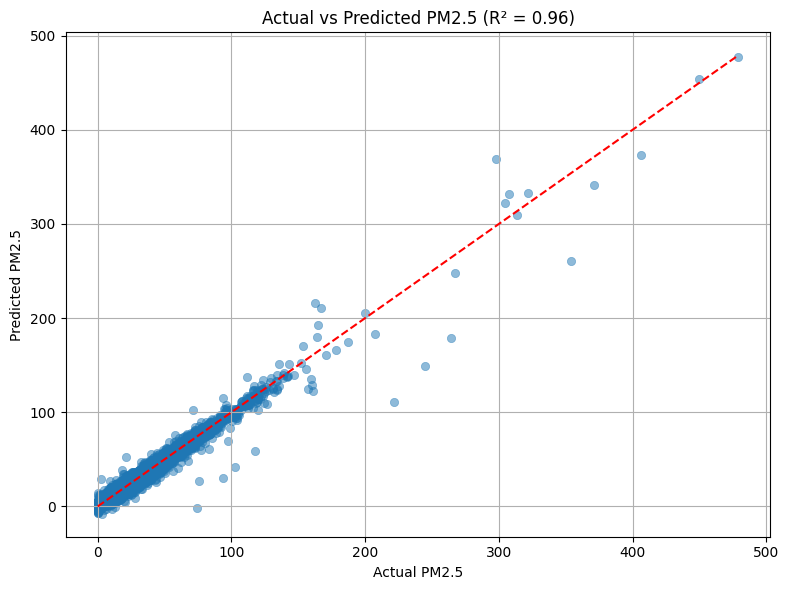

In [31]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, edgecolor=None)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title(f'Actual vs Predicted PM2.5 (R² = {r2_score(y_test, y_pred):.2f})')
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
y_val

88982     11.190
88983      7.019
88984      6.033
88985      7.967
88986     12.030
           ...  
103290    23.430
103291    29.240
103292    31.590
103293    27.970
103294    24.740
Name: PM2.5_t+1, Length: 14313, dtype: float64

# Testing out XGBoost Regressor and Random Forrest Regressor

In [33]:
X = pd.concat([df_train[features], df_test[features]])#data_for_model[features]
y = pd.concat([df_train['PM2.5_t+1'], df_test['PM2.5_t+1']])#data_for_model['PM2.5_t+3']

In [34]:
#Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [35]:
#Random Forrest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)


In [36]:
#XGBoost
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)


## Model Evaluation

In [37]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Performance:")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))
    print("R2 Score:", r2_score(y_true, y_pred))

evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("XGBoost", y_test, xgb_preds)



Random Forest Performance:
MAE: 2.557844765971793
RMSE: 4.080701444111681
R2 Score: 0.9516976209122294

XGBoost Performance:
MAE: 2.553517061289299
RMSE: 4.067351064799688
R2 Score: 0.952013155013808


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 1.0, 'Random Forest: Actual vs Predicted')

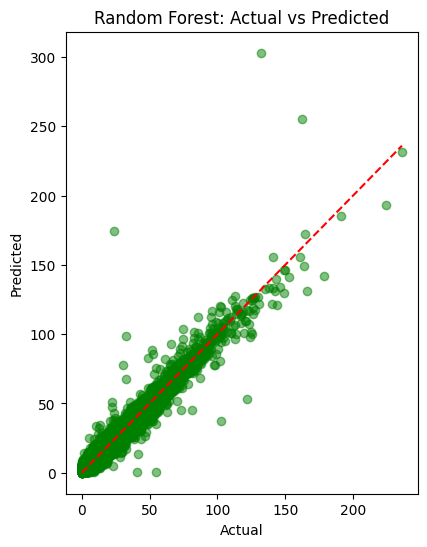

In [38]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, rf_preds, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest: Actual vs Predicted")

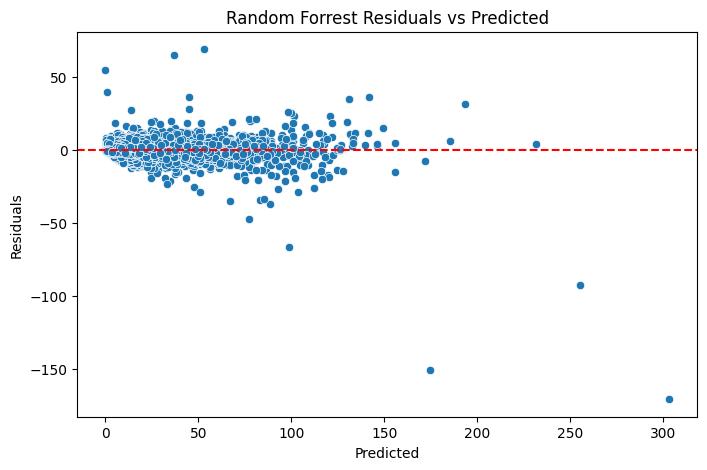

In [39]:
residuals = y_test - rf_preds

plt.figure(figsize=(8, 5))
sns.scatterplot(x=rf_preds, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Random Forrest Residuals vs Predicted")
plt.show()

Text(0.5, 1.0, 'XGBoost: Actual vs Predicted')

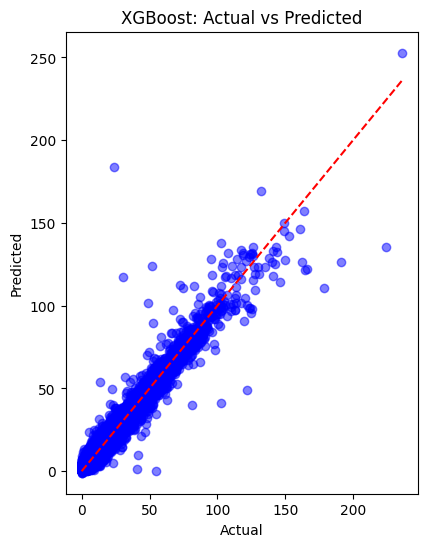

In [40]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 2)
plt.scatter(y_test, xgb_preds, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost: Actual vs Predicted")

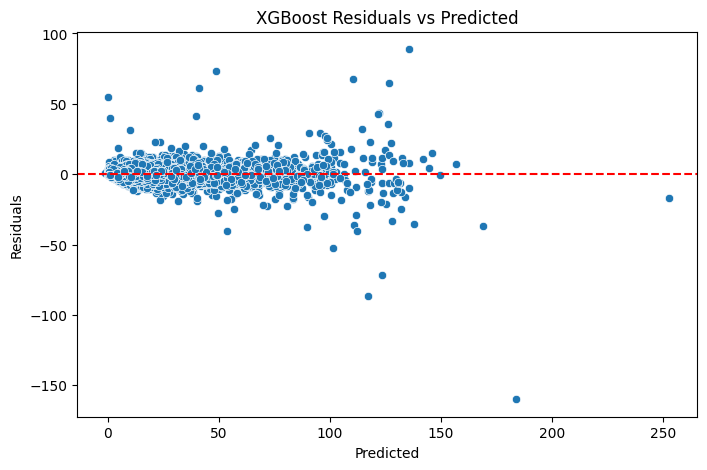

In [41]:
residuals = y_test - xgb_preds

plt.figure(figsize=(8, 5))
sns.scatterplot(x=xgb_preds, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("XGBoost Residuals vs Predicted")
plt.show()

In [42]:
#Validation performance

rf_val = rf.predict(X_val)

xgb_val = xgb.predict(X_val)

evaluate_model("Random Forrest", y_val, rf_val)
evaluate_model("XGBoost", y_val, xgb_val )


Random Forrest Performance:
MAE: 2.7024893753929993
RMSE: 4.543335296825333
R2 Score: 0.9376101423603129

XGBoost Performance:
MAE: 2.708663621966641
RMSE: 5.413746145911927
R2 Score: 0.911414999455667


c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Shivm\Documents\Masters\.venv\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 1.0, 'Random Forest Validation: Actual vs Predicted')

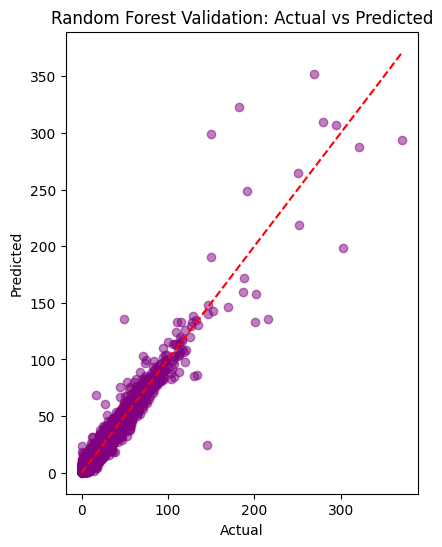

In [43]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(y_val, rf_val, alpha=0.5, color='purple')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest Validation: Actual vs Predicted")

Text(0.5, 1.0, 'XGBoost Validation: Actual vs Predicted')

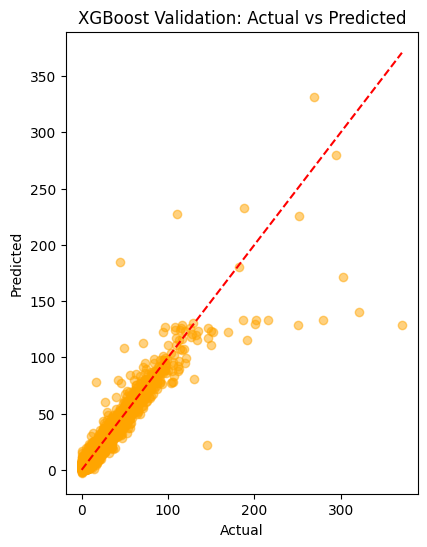

In [44]:
plt.figure(figsize=(10,6))
plt.subplot(1, 2, 1)
plt.scatter(y_val, xgb_val, alpha=0.5, color='orange')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')  # ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("XGBoost Validation: Actual vs Predicted")

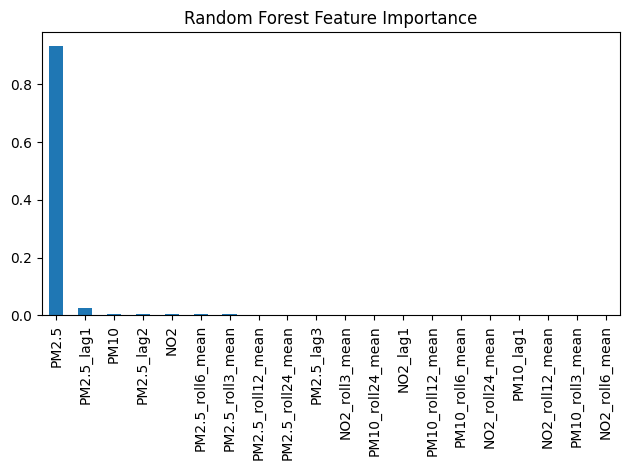

In [45]:
import matplotlib.pyplot as plt

# For Random Forest
rf_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
rf_importance.plot(kind='bar', title='Random Forest Feature Importance')
plt.tight_layout()
plt.show()




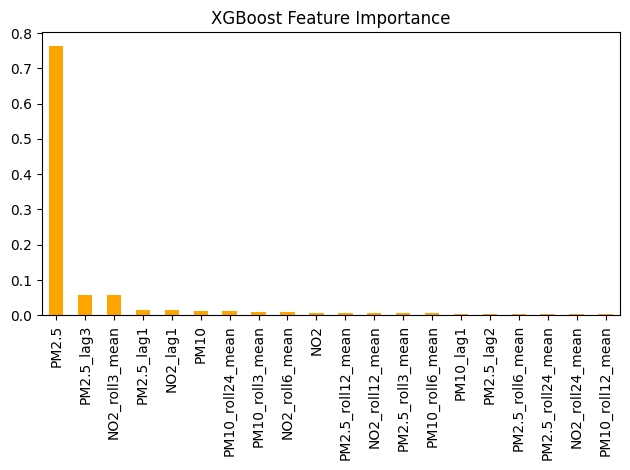

In [46]:
# For XGBoost
xgb_importance = pd.Series(xgb.feature_importances_, index=features).sort_values(ascending=False)
xgb_importance.plot(kind='bar', title='XGBoost Feature Importance', color='orange')
plt.tight_layout()
plt.show()